# Importing the data

## Import Libraries

In [162]:
# import system libraries
import os
import itertools
from PIL import Image
import cv2
from matplotlib.image import imread

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# import Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras import regularizers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

figsize = (20, 8)
fontsize = 20
lablesize = 14

In [163]:
data_dir = 'Bird_Species_Dataset' 
#the code file should be in the same folder as the folder called 'Bird Species Dataset' thus this is the path to the folder containing the dataset
filepaths, image_list, label_list = [], [], []

folders = os.listdir(data_dir)

#print(folders)

for fold in folders:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)
    for f in flist:
        fpath = os.path.join(foldpath, f)
        filepaths.append(fpath)
        label_list.append(fold)

print(filepaths)
print(label_list)

for file in filepaths:
    image = cv2.imread(file)
    image = img_to_array(image)
    image_list.append(image)
    
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(label_list, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

['Bird_Species_Dataset/AMERICAN GOLDFINCH/001.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/002.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/003.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/004.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/005.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/006.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/007.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/008.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/009.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/010.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/011.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/012.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/013.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/014.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/015.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/016.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/017.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/018.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/019.jpg', 'Bird_Species_Dataset/AMERICAN

In [164]:
df['labels'].value_counts()

labels
AMERICAN GOLDFINCH    143
EMPEROR PENGUIN       139
DOWNY WOODPECKER      137
FLAMINGO              132
CARMINE BEE-EATER     131
BARN OWL              129
Name: count, dtype: int64

In [165]:
np.shape(image_list)

(811, 224, 224, 3)

### Plot bird-pictures

In [166]:
"""num_images = 6

# Get unique bird species labels
bird_species = df['labels'].unique()

# Set up the plot
plt.figure(figsize=(20, 20))

# Loop through each bird species
for idx, bird in enumerate(bird_species):
    # Filter the DataFrame to get file paths for this bird species
    bird_df = df[df['labels'] == bird].sample(num_images)  # Get a random sample of 16 images
    
    # Loop through the 16 images and plot them
    for i, file in enumerate(bird_df['filepaths'].values):
        plt.subplot(len(bird_species), num_images, idx * num_images + i + 1)
        img = Image.open(file)
        plt.imshow(img)
        plt.axis('off')
        plt.title(bird)
        
# Show the plot
plt.tight_layout()
plt.show()"""

"num_images = 6\n\n# Get unique bird species labels\nbird_species = df['labels'].unique()\n\n# Set up the plot\nplt.figure(figsize=(20, 20))\n\n# Loop through each bird species\nfor idx, bird in enumerate(bird_species):\n    # Filter the DataFrame to get file paths for this bird species\n    bird_df = df[df['labels'] == bird].sample(num_images)  # Get a random sample of 16 images\n    \n    # Loop through the 16 images and plot them\n    for i, file in enumerate(bird_df['filepaths'].values):\n        plt.subplot(len(bird_species), num_images, idx * num_images + i + 1)\n        img = Image.open(file)\n        plt.imshow(img)\n        plt.axis('off')\n        plt.title(bird)\n        \n# Show the plot\nplt.tight_layout()\nplt.show()"

### Splitting Data 

In [167]:
# Splitting dataset
strat = df['labels']
train_df, dummy_df = train_test_split(df, test_size=.3, shuffle=True, stratify=strat, random_state=123)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, test_size=.5, shuffle=True, stratify=strat, random_state=123)


print(f"Number of Training dataset: {len(train_df)}\nNumber of Validation dataset: {len(valid_df)}\nNumber of Testing dataset: {len(test_df)}")

# NOTE: stratify = strat -> equal proportions of bird-labels in each data-substet (Train/Test/Val) as original data 

Number of Training dataset: 567
Number of Validation dataset: 122
Number of Testing dataset: 122


### ImageDataGenerator()-THING, FIND GOOD TITLE

In [168]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', 
                                       color_mode='rgb', shuffle= True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)


print(tr_gen)

Found 567 validated image filenames belonging to 6 classes.
Found 122 validated image filenames belonging to 6 classes.
Found 122 validated image filenames belonging to 6 classes.


### Images Structure

In [169]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

## CNN function

In [170]:

def CNN(eta, lmbd, n_filters, n_conv, n_pool, n_neurons, act_func, optimizer, extra_dense_layers=None):
    model = Sequential([
        Conv2D(n_filters, (n_conv,n_conv), activation=act_func, padding='same', input_shape = img_shape, kernel_regularizer=regularizers.l2(lmbd)),
        MaxPooling2D((n_pool,n_pool)),

        Conv2D(n_filters*2, (n_conv,n_conv), activation=act_func, padding='same', kernel_regularizer=regularizers.l2(lmbd)),
        MaxPooling2D((n_pool,n_pool)),
        
        Flatten(),
        Dense(n_neurons, activation=act_func, kernel_regularizer=regularizers.l2(lmbd)),
        #Dense(class_count, activation='softmax')
    ]) 

    # Add any additional dense layers specified in extra_dense_layers
    if extra_dense_layers:
        for n_neurons in extra_dense_layers:
            model.add(Dense(n_neurons, activation=act_func, kernel_regularizer=regularizers.l2(lmbd)))
    
    # Add the final output layer for classification
    model.add(Dense(class_count, activation='softmax'))
    
    
    #model.compile(Adam(learning_rate = eta), loss = 'categorical_crossentropy', metrics=['acc'])
    model.compile(optimizer(learning_rate = eta), loss = 'categorical_crossentropy', metrics=['acc'])
    # NOTES: 
    # INFO: tf.keras.Sequential   -> look at: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

    # compile(...,  loss = 'categorical_crossentropy')  -> Computes the crossentropy loss between the labels and predictions.
    
    return model




# -- If want to add Conv. or Pool. layer, then add:
# model.add(layers.Conv2D(n_filters, (n_conv, n_conv), input_shape=input_shape, padding='same', activation=act_func, kernel_regularizer=regularizers.l2(lmbd)))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# maybe can include: 
#       Conv2D(16, (3,3), activation=act_func, padding='same', kernel_regularizer=L2(lmd)),
#       MaxPooling2D((2,2)),

### Comparison $\lambda$ vs. $\eta$ with CNN model 

In [ ]:
# Set seed for reproducibility
seed = 2024
tf.keras.backend.clear_session()     # Clear any previous model session
tf.keras.utils.set_random_seed(seed) # must include for reproducibility 

# ------------------ Setting up parameters

# ---- Fixed Parameters trought project----
n_filters = 6
n_conv = 3
n_pool = 2
n_neurons = 50
epochs = 10 #use 100 inittialy
# -----------------------------------------

batch_size = 10
act_func = 'relu'
optimizer = tf.keras.optimizers.Adam 
# Have implemented optimizer for futere work
# if want to test with different otimizers, ex Adamax etc..


In [ ]:
# This is for testing
lmbd_list = np.logspace(-1,0,2)
lmbd_list[0] = 0 # setting first elemenent to include no L2-penalty
eta_list = np.logspace(-3,-2, 2)

bool_final_run = False
if bool_final_run:
    # Defining parameter-space to search for optimal fit
    max_lmbd = -4
    max_eta = -4
    N_lmbd = abs(max_lmbd) + 1
    N_eta = abs(max_eta) + 1

    lmbd_list = np.logspace(max_lmbd, 0, N_lmbd)
    lmbd_list[0] = 0 # setting first elemenent to include no L2-penalty
    eta_list = np.logspace(max_eta, 0, N_eta)



print("lmbd = ", lmbd_list)
print("eta  = ", eta_list)



CNN_model_list = []
fit_list       = []
for lmbd in lmbd_list:
    for eta in eta_list:
        # ---------------- Making model
        CNN_model = CNN(eta, lmbd, n_filters, n_conv, n_pool, n_neurons, act_func, optimizer)
        print("------------------------- SUMMARY --------------------------")
        CNN_model.summary()

        # ---------------- Fitting to training data
        print(f'\n\n lmbd = {lmbd}, eta = {eta} \n')
        fit = CNN_model.fit(x= train_gen, epochs=epochs, batch_size=batch_size, validation_data=valid_gen, verbose=1) #, callbacks=[early_stopping, plateau])

        CNN_model_list.append(CNN_model)
        fit_list.append([fit, lmbd, eta])
        

lmbd =  [0.   0.01 0.1  1.  ]
eta  =  [0.001 0.01  0.1   1.   ]
------------------------- SUMMARY --------------------------
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 3136)              0     

### Performance Scores: $\lambda$ vs. $\eta$

In [175]:
def plot_accuracy_evoluton(fit_list, string1, string2, png_name):
    plt.figure(figsize=figsize)
    plt.style.use('fivethirtyeight')

    # Loop through fit_list to plot each fit's validation accuracy
    for fit, var1, var2 in fit_list: 
        tr_acc = fit.history['acc']
        val_acc = fit.history['val_acc']
        if val_acc[-1] < 0.5: #not plot if last accuracy < 0.5
            continue  

        index_acc = np.argmax(val_acc)
        Epochs = [i+1 for i in range(len(tr_acc))]

        #   Un-mark this if want dot for highest val_acc
        #acc_highest = val_acc[index_acc]
        #acc_label = f'best epoch = {str(index_acc + 1)}'
        #plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
        # Explenations: tr_ = training, val_ = validation

        #plt.plot(Epochs, tr_acc, label= 'Training Accuracy')
        if isinstance(var1, str):
            if isinstance(var2, str):
                plt.plot(Epochs, val_acc, label= f'{string1} = {var1}, {string2} = {var2}')
            else: 
                plt.plot(Epochs, val_acc, label= f'{string1} = {var1}, {string2} = {var2:g}')
        elif isinstance(var2, str):
            plt.plot(Epochs, val_acc, label= f'{string1} = {var1:3g}, {string2} = {var2}')
        elif isinstance(var2, list):
            plt.plot(Epochs, val_acc, label= f'{string1} = {var1:3g}, {string2} = {var2}')
        else:
            plt.plot(Epochs, val_acc, label= f'{string1} = {var1:3g}, {string2} = {var2}')


    plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1, label='Cutoff') # cutoff, only include val_acc[-1] > cutoff = 0.5
    plt.suptitle(rf'CNN      -      Validation Accuracy   -   {string1}  vs. {string2}', fontsize=fontsize)
    plt.title(r"", fontsize=fontsize-5)
    plt.xlabel('Epochs', fontsize=lablesize)
    plt.ylabel('Accuracy', fontsize=lablesize)
    plt.legend()

    plt.tight_layout
    plt.savefig("CNN_plots/" + png_name + ".png")



def plot_heatmap(fit_list, var1, var2, string1, string2, png_name):
    val_acc = [] # list with all accuracy scores for validation set
    for fit, _, _ in fit_list:
        val_acc.append(fit.history['val_acc'][-1])

    #var1 = lmbd_list
    #var2 = eta_list

    val_acc_heatmap = np.array(val_acc).reshape( (len(var1), len(var2)) )

    # Find index for maximum val_acc
    index_max_val_acc = np.argmax(val_acc_heatmap)
    index_max_2d = np.unravel_index(index_max_val_acc, val_acc_heatmap.shape)

    # Create heatmap
    plt.figure(figsize=(8, 6))
    plt.style.use('fivethirtyeight')

    sns.heatmap(val_acc_heatmap, annot=True, cmap="coolwarm", xticklabels=var2, yticklabels=var1)
    # Get the row and column to highlight highest accuracy
    # Draw lines around the specified cell
    row, col = index_max_2d
    plt.vlines(col, row, row + 1, color='yellow', linewidth=2)  # Left vertical
    plt.vlines(col + 1, row, row + 1, color='yellow', linewidth=2)  # Right vertical
    plt.hlines(row, col, col + 1, color='yellow', linewidth=2)  # Bottom horizontal
    plt.hlines(row + 1, col, col + 1, color='yellow', linewidth=2)  # Top horizontal

    plt.suptitle(r'CNN      -      Validation Accuracy', fontsize=fontsize)
    plt.title(rf"{string1}  vs. {string2}", fontsize=fontsize)
    plt.xlabel(rf"{string2}", fontsize = lablesize)
    plt.ylabel(rf"{string1}", fontsize = lablesize)

    plt.savefig("CNN_plots/" + png_name + ".png")

    return index_max_val_acc, index_max_2d
    
    

--------- Optimal Fit (according to Validation Accuracy)--------------
Accuracy(lmbd = 0.1, eta = 0.001) = 0.820


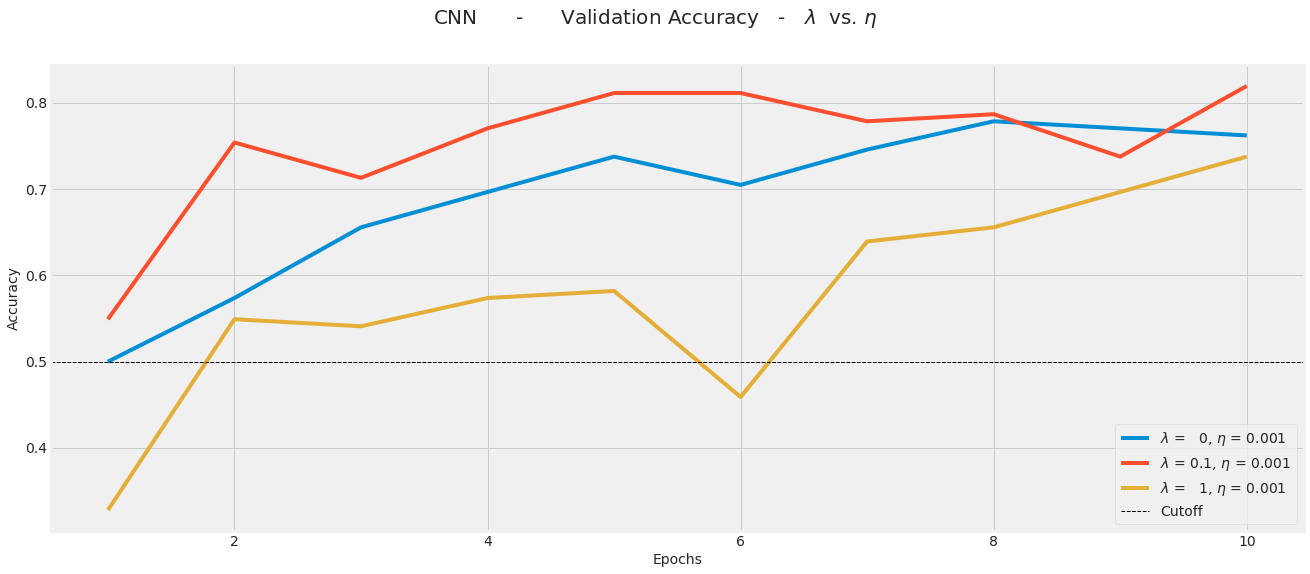

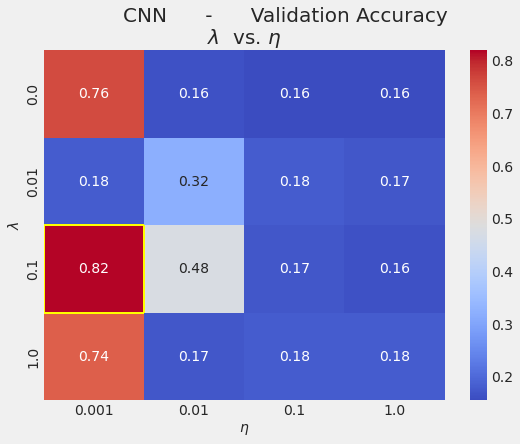

In [176]:

string1 = '$\lambda$'
string2 = '$\eta$'
png_name = 'val_acc_' + string1 + "_" + string2
plot_accuracy_evoluton(fit_list, string1, string2, png_name)


var1 = lmbd_list
var2 = eta_list
png_name = 'heatmap_val_acc' + string1 + "_" + string2
index_max_val_acc, index_max_2d =  plot_heatmap(fit_list, var1, var2, string1, string2, png_name)





# ---------------------------- Selecting optimal fit for lmbd vs. eta (according to Validation Accuracy)
# Save CNN model & parameters for future use 
CNN_model = CNN_model_list[index_max_val_acc]
fit, lmbd, eta = fit_list[index_max_val_acc] 

val_acc_optimal = fit.history['val_acc'][-1]


print("--------- Optimal Fit (according to Validation Accuracy)--------------")
print(f"Accuracy(lmbd = {lmbd}, eta = {eta}) = {val_acc_optimal:.3f}")


# Define needed variables
tr_acc = fit.history['acc']
tr_loss = fit.history['loss']
val_acc = fit.history['val_acc']
val_loss = fit.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch = {str(index_loss + 1)}'
acc_label = f'best epoch = {str(index_acc + 1)}'



### Comparison Activation Functions vs. Batch Size (M)  with CNN model 

In [ ]:
tf.keras.utils.set_random_seed(seed) # must include for reproducibility 


# Defining parameter-space to search for optimal fit
batch_size_list = [10, 15]  # batch_size_list = np.linspace(5,20,4)
act_func_list = ['relu', 'leaky_relu'] 
# act_func-string must match tf.keras.activations found at https://www.tensorflow.org/api_docs/python/tf/keras/activations

bool_final_run = False
if bool_final_run:
    # Defining parameter-space to search for optimal fit
    
    batch_size_list = np.linspace(5,50,9)
    act_func_list = ['relu', 'leaky_relu'] 
    # act_func-string must match tf.keras.activations found at https://www.tensorflow.org/api_docs/python/tf/keras/activations



print("batch_size_list = ", batch_size_list)
print("act_func_list  = ", act_func_list)



CNN_model_list = []
fit_list       = []
for batch_size in batch_size_list:
    for act_func in act_func_list:
        # ---------------- Making model
        CNN_model = CNN(eta, lmbd, n_filters, n_conv, n_pool, n_neurons, act_func, optimizer)
        print("------------------------- SUMMARY --------------------------")
        CNN_model.summary()

        # ---------------- Fitting to training data
        print(f'\n\n batch_size = {batch_size}, act_func = {act_func} \n')
        fit = CNN_model.fit(x= train_gen, epochs=epochs, batch_size=batch_size, validation_data=valid_gen, verbose=1) #, callbacks=[early_stopping, plateau])

        CNN_model_list.append(CNN_model)
        fit_list.append([fit, batch_size, act_func])
        

batch_size_list =  [ 5.   16.25 27.5  38.75 50.  ]
act_func_list  =  ['relu', 'leaky_relu']
------------------------- SUMMARY --------------------------
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 56, 56, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 56, 56, 16)        1168      
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_19 (Flatten)        (No

71/71 [==============================] - 3s 38ms/step - loss: 4.6048 - acc: 0.5908 - val_loss: 4.5556 - val_acc: 0.5656
Epoch 9/10
71/71 [==============================] - 3s 39ms/step - loss: 4.3050 - acc: 0.6243 - val_loss: 4.3123 - val_acc: 0.5902
Epoch 10/10
71/71 [==============================] - 8s 111ms/step - loss: 4.1052 - acc: 0.6208 - val_loss: 4.1383 - val_acc: 0.5574
------------------------- SUMMARY --------------------------
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 56, 56, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 56, 56, 16)        1168      
    

### Performance Scores: Activation Functions vs. Batch Size (M)

--------- Optimal Fit (according to Validation Accuracy)--------------
Accuracy(batch_size = 27.5, act_func = leaky_relu) = 0.861


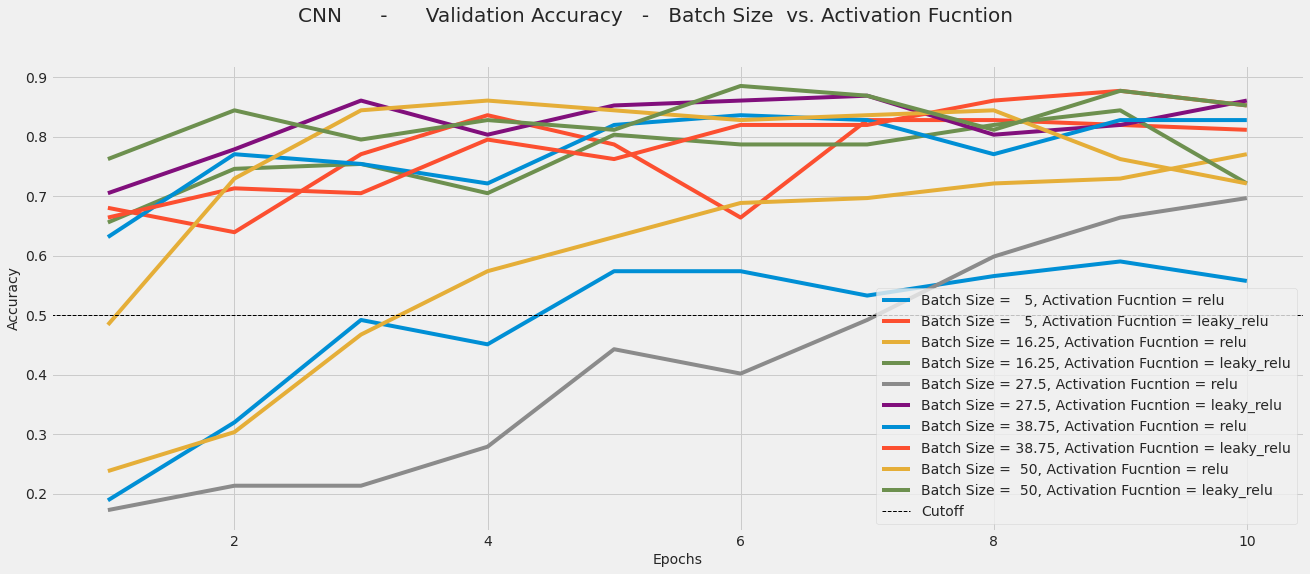

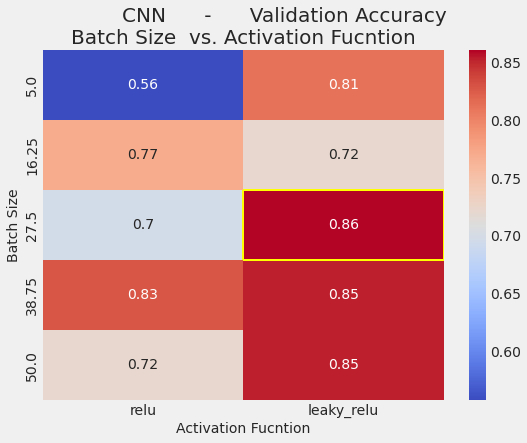

In [178]:
string1 = 'Batch Size'
string2 = 'Activation Fucntion'
png_name = 'val_acc_' + string1 + "_" + string2
plot_accuracy_evoluton(fit_list, string1, string2, png_name)


var1 = batch_size_list
var2 = act_func_list
png_name = 'heatmap_val_acc' + string1 + "_" + string2
index_max_val_acc, index_max_2d =  plot_heatmap(fit_list, var1, var2, string1, string2, png_name)




# ---------------------------- Selecting optimal fit for lmbd vs. eta (according to Validation Accuracy)
# Save CNN model & parameters for future use 
CNN_model = CNN_model_list[index_max_val_acc]
fit, batch_size, act_func = fit_list[index_max_val_acc] 

val_acc_optimal = fit.history['val_acc'][-1]


print("--------- Optimal Fit (according to Validation Accuracy)--------------")
print(f"Accuracy(batch_size = {batch_size}, act_func = {act_func}) = {val_acc_optimal:.3f}")


# Define needed variables
tr_acc = fit.history['acc']
tr_loss = fit.history['loss']
val_acc = fit.history['val_acc']
val_loss = fit.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch = {str(index_loss + 1)}'
acc_label = f'best epoch = {str(index_acc + 1)}'



In [ ]:
tf.keras.utils.set_random_seed(seed) # must include for reproducibility 


# Defining parameter-space to search for optimal fit
n_neurons_list = [40,50] # np.linspace(10,80,8)
k = 20 # n_neurons in extra layer. Can change k
extra_dense_layer_list = [None, [k],[k,k]] 

bool_final_run = False
if bool_final_run:
    n_neurons_list = np.linspace(10,100,9)
    k = 50 # n_neurons in extra layer
    extra_dense_layer_list = [None, [k],[k,k]] 




print("n_neurons_list = ", n_neurons_list)
print("extra_dense_layer_list  = ", extra_dense_layer_list)



CNN_model_list = []
fit_list       = []
for n_neurons in n_neurons_list:
    for extra_dense_layer in extra_dense_layer_list:
        # ---------------- Making model
        CNN_model = CNN(eta, lmbd, n_filters, n_conv, n_pool, n_neurons, act_func, optimizer, extra_dense_layers=extra_dense_layer)
        print("------------------------- SUMMARY --------------------------")
        CNN_model.summary()

        # ---------------- Fitting to training data
        print(f'\n\n n_neurons = {n_neurons}, extra_dense_layer = {extra_dense_layer} \n')
        fit = CNN_model.fit(x= train_gen, epochs=epochs, batch_size=batch_size, validation_data=valid_gen, verbose=1) #, callbacks=[early_stopping, plateau])

        CNN_model_list.append(CNN_model)
        fit_list.append([fit, n_neurons, extra_dense_layer])
        

n_neurons_list =  [ 10.          22.85714286  35.71428571  48.57142857  61.42857143
  74.28571429  87.14285714 100.        ]
extra_dense_layer_list  =  [None, [50], [50, 50]]
------------------------- SUMMARY --------------------------
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 56, 56, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 56, 56, 16)        1168      
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
               

71/71 [==============================] - 3s 42ms/step - loss: 2.9574 - acc: 0.9506 - val_loss: 3.3849 - val_acc: 0.8197
Epoch 8/10
71/71 [==============================] - 4s 63ms/step - loss: 2.7936 - acc: 0.9612 - val_loss: 3.4127 - val_acc: 0.7623
Epoch 9/10
71/71 [==============================] - 6s 86ms/step - loss: 2.6598 - acc: 0.9594 - val_loss: 3.2060 - val_acc: 0.8033
Epoch 10/10
71/71 [==============================] - 3s 40ms/step - loss: 2.5778 - acc: 0.9594 - val_loss: 3.5062 - val_acc: 0.7377
------------------------- SUMMARY --------------------------
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 56, 56, 8)         0         
 ng2D)                                                           
      

--------- Optimal Fit (according to Validation Accuracy)--------------
Accuracy(n_neurons = 48.57142857142857, extra_dense_layer = None) = 0.926


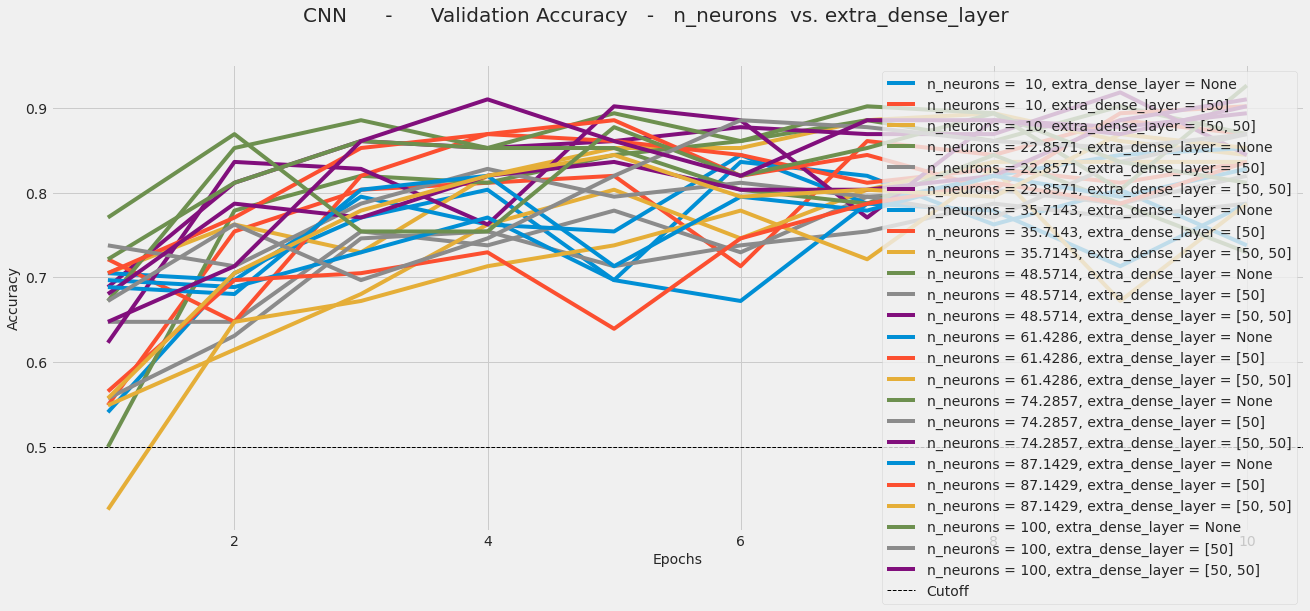

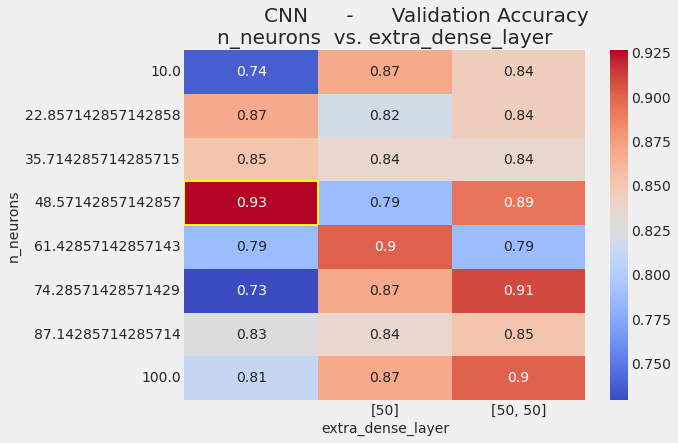

In [180]:
string1 = 'n_neurons'
string2 = 'extra_dense_layer'
png_name = 'val_acc_' + string1 + "_" + string2
plot_accuracy_evoluton(fit_list, string1, string2, png_name)

var1 = n_neurons_list
var2 = extra_dense_layer_list
png_name = 'heatmap_val_acc' + string1 + "_" + string2
index_max_val_acc, index_max_2d =  plot_heatmap(fit_list, var1, var2, string1, string2, png_name)




# ---------------------------- Selecting optimal fit for lmbd vs. eta (according to Validation Accuracy)
# Save CNN model & parameters for future use 
CNN_model = CNN_model_list[index_max_val_acc]
fit, n_neurons, extra_dense_layer = fit_list[index_max_val_acc] 

val_acc_optimal = fit.history['val_acc'][-1]


print("--------- Optimal Fit (according to Validation Accuracy)--------------")
print(f"Accuracy(n_neurons = {n_neurons}, extra_dense_layer = {extra_dense_layer}) = {val_acc_optimal:.3f}")


# Define needed variables
tr_acc = fit.history['acc']
tr_loss = fit.history['loss']
val_acc = fit.history['val_acc']
val_loss = fit.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch = {str(index_loss + 1)}'
acc_label = f'best epoch = {str(index_acc + 1)}'



# Running Final Model


In [185]:
# ---------------- Making model
CNN_model = CNN(eta, lmbd, n_filters, n_conv, n_pool, n_neurons, act_func, optimizer)
print("------------------------- SUMMARY --------------------------")
CNN_model.summary()

fit = CNN_model.fit(x= train_gen, epochs=epochs, batch_size=batch_size, validation_data=valid_gen, verbose=1) #, callbacks=[early_stopping, plateau])

------------------------- SUMMARY --------------------------
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_106 (MaxPool  (None, 56, 56, 8)         0         
 ing2D)                                                          
                                                                 
 conv2d_107 (Conv2D)         (None, 56, 56, 16)        1168      
                                                                 
 max_pooling2d_107 (MaxPool  (None, 14, 14, 16)        0         
 ing2D)                                                          
                                                                 
 flatten_53 (Flatten)        (None, 3136)              0         
                                                          

## Performance Scores 
### Optimal $\lambda$, $\eta$, (should be Activation Functions, Batch Size (M), # Hidden Layers, # Hidden Nodes) 

#### Training & Validation - Cross Entropy Loss 

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

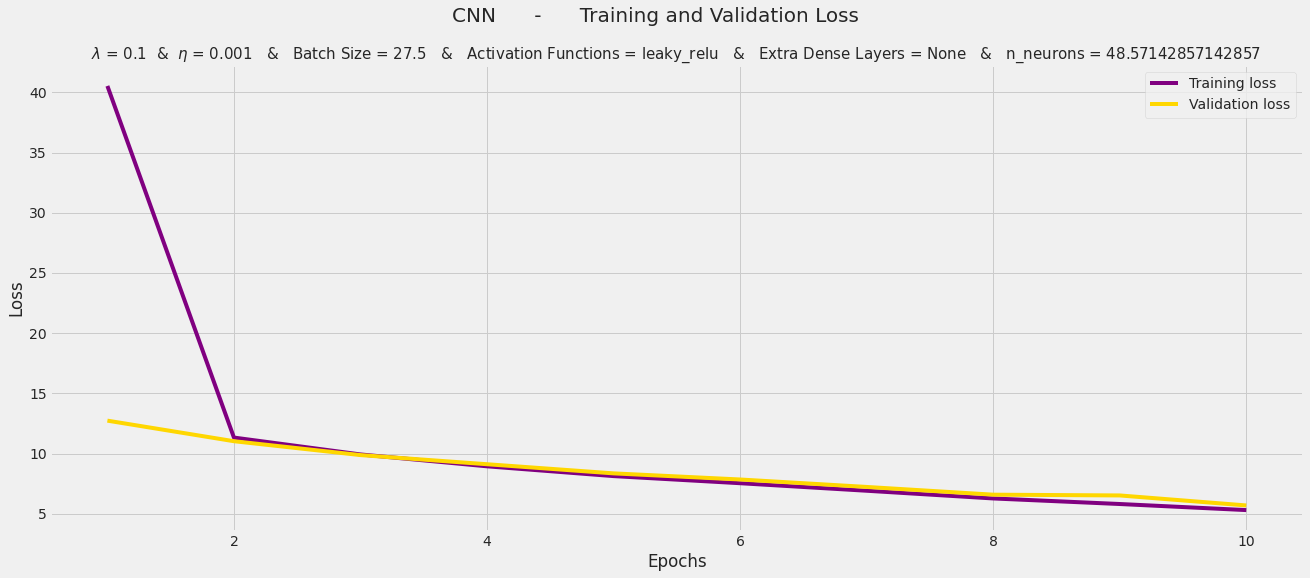

In [186]:
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_loss, 'purple', label= 'Training loss')
plt.plot(Epochs, val_loss, 'gold', label= 'Validation loss')

parameter_string = rf"$\lambda$ = {lmbd}  &  $\eta$ = {eta}   &   Batch Size = {batch_size}   &   Activation Functions = {act_func}   &   Extra Dense Layers = {extra_dense_layer}   &   n_neurons = {n_neurons} "
parameter_string_wrapped = rf"$\lambda$ = {lmbd}  &  $\eta$ = {eta}   &   Batch Size = {batch_size}   &   Activation Functions = {act_func} " + "\n" + f"Extra Dense Layers = {extra_dense_layer}   &   n_neurons = {n_neurons} "
#plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.suptitle('CNN      -      Training and Validation Loss', fontsize=fontsize)
plt.title(parameter_string, fontsize=fontsize-5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout
#plt.savefig("CNN_plots/train_val_loss.png")

#### Training & Validation - Accuracy

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

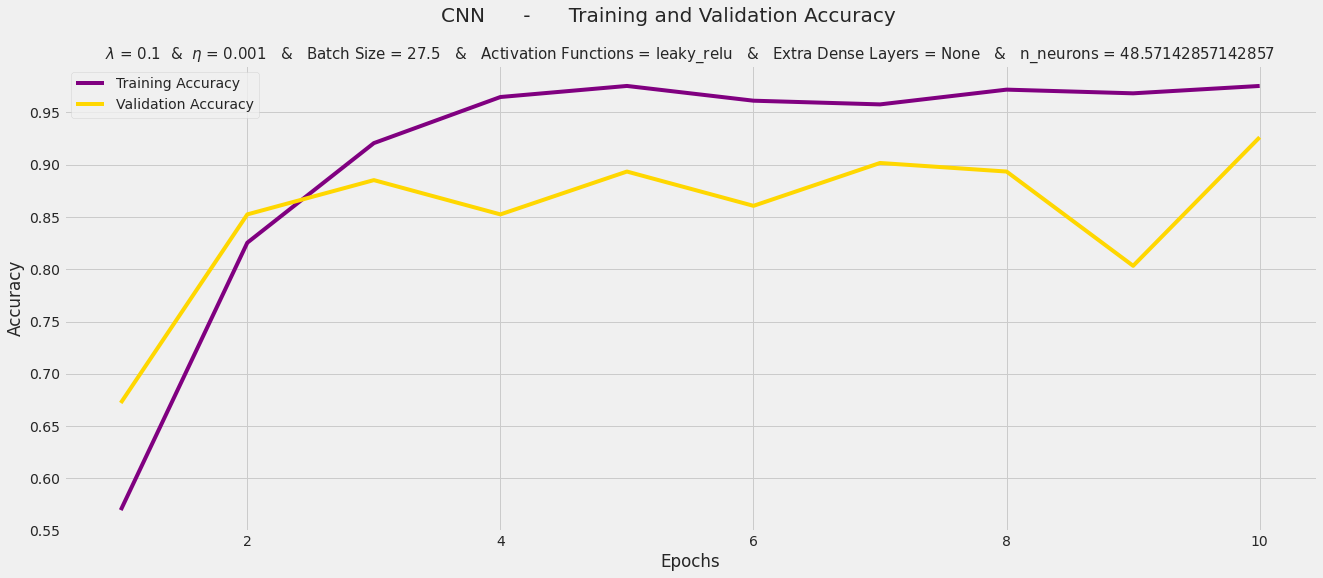

In [187]:
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_acc, 'purple', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'gold', label= 'Validation Accuracy')
#plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.suptitle('CNN      -      Training and Validation Accuracy', fontsize=fontsize)
plt.title(parameter_string, fontsize=fontsize-5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
#plt.savefig("CNN_plots/train_val_acc.png")

### Make Predictions

16/16 [==============================] - 1s 43ms/step


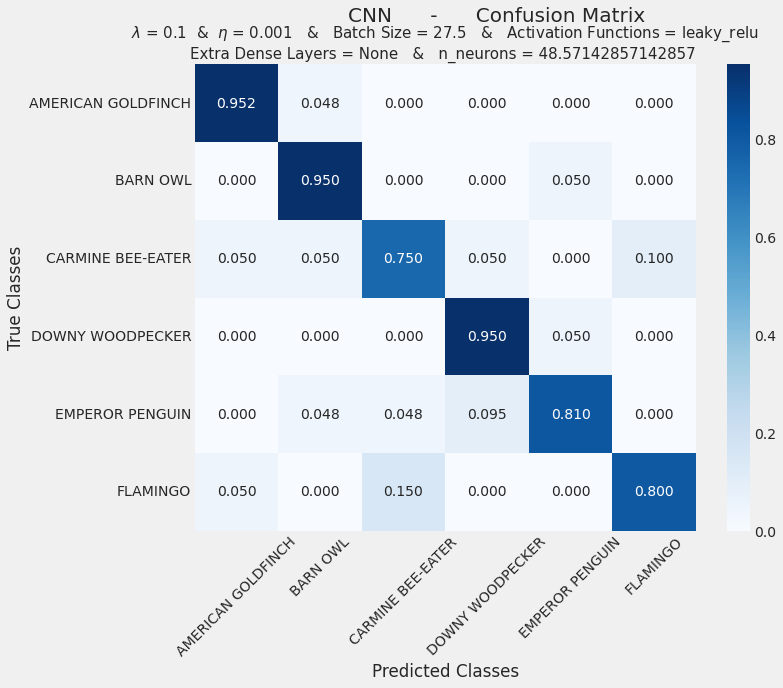

In [188]:
# Make Predictions
preds  = CNN_model.predict(test_gen) # Probabilities 6 labes   shape (122, 6)

y_pred = np.argmax(preds, axis=1)    # Most probable label     shape (122,)


# -------------------------.-- Plot Confusion matrix --------------------------------------
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred, normalize='true') 
# normalize = 'true' -> get respective accuracy scores  
# sum each row = 1 

# Create a heat map
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, fmt='.3f') #,  fmt='d')


plt.suptitle('CNN      -      Confusion Matrix', fontsize=fontsize)
plt.title(parameter_string_wrapped, fontsize=fontsize-5)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')

# Modify the rotation of axis labels
plt.xticks(rotation=45)  # Rotation of x-axis labels
plt.yticks(rotation=0)   # Rotation of y-axis labels
plt.show()




### Final Evaluation Model

In [189]:
train_score = CNN_model.evaluate(train_gen, verbose=1)
valid_score = CNN_model.evaluate(valid_gen, verbose=1)
test_score  = CNN_model.evaluate(test_gen, verbose=1)
# .evaluate gives list of score ["Cross_Entropy_Loss", "Accuracy"]

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


16/16 [==============================] - 0s 21ms/step - loss: 4.1344 - acc: 0.8689
Train Loss:  3.5245919227600098
Train Accuracy:  0.998236358165741
--------------------
Valid Loss:  3.912802219390869
Valid Accuracy:  0.8770492076873779
--------------------
Test Loss:  4.134416103363037
Test Accuracy:  0.868852436542511
